# Principle Component Analysis (PCA)
PCA is a linear dimensionality reduction technique which transforms data into a new basis that aligns with directions of maximum variability as linear combinations of the original axes. In order to reduce dimensionality the first $n$ (most significant) new axes (principle components) can be used to transform the data into latent space $Z$ and from there inversely transform them into input space $X$. If the $n$ principle components can't account for all variability in the data, the compression into $Z$ is lossy; the reverse transformation cannot recover all information. PCA sometimes helps to make sense of (i.e. interpret) latent features inherent in the data (i.e. intrinsic data attributes).

In [1]:
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import tensorflow as tf
import dataset

from scipy.linalg import eigh

In [2]:
expl_idx = 0
vmin, vmax = -128, 128
nrows, ncols = 64, 64
nsamples = 10_000
ncomponents = 3

### 1. Generate data
* Centered circles of random radius
* Most efficient: Parameterize circles by radius as (single) latent variable
* Encoding and Reconstruction of circle (area) is non-linear problem: $A=\pi r^2$ $\rightarrow$ Expect PCA to need >1 component to cover 100% of data variability.

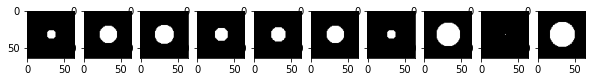

In [3]:
data = dataset.construct(nsamples, nrows, ncols, "circle")

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(data[i].reshape(nrows, ncols), vmin=0, vmax=255)

### 2. Find covariance matrix
$cov(X)= \frac{\tilde{X}^T\tilde{X}}{N-1}$ with $\tilde{X} = X - \mu_X$ (centered around 0)

In [4]:
X = data - data.mean(axis=0)
cov = (X.T @ X) / (nsamples-1)

print(X.shape, X[ X != 0 ])

(10000, 4096) [-8.058 -8.058 -8.058 ... -8.058 -8.058 -8.058]


### 3. Find eigenvectors and eigenvalues
PCA can be accomplished either by eigendecomposition of the data's covariance matrix or by singular value decomposition directly on the dataset $X$ (which is a generalization of the former). Here, eigendecomposition, the simpler of the two, is implemented for illustration. 

In PCA, the eigenvectors of the cov matrix yield the new (orthonormal) basis vectors, the principle components, whose corresponding eigenvalues are interpreted as the amount of variance a new axis accounts for wrt the total amount of variance in the data. Indeed, the trace of the covariance matrix is equal to the sum of all eigenvalues.

In [5]:
eigvals, eigvecs = eigh(cov) # increasing order
eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1] # decreasing order

print(eigvals.shape, eigvecs.shape)
print(np.trace(cov), eigvals.sum()) # eigenvals interpreted as 'accounted variance'

(4096,) (4096, 4096)
33457830.0 33457820.0


### 4. Plot encoding-decoding performance
* As expected, one axis is not enough to describe all variability of the data (i.e. to describe the intrinsic attribute used to generate the data)
* 80% of data variability are accounted by first PC.
* Abt. 20 PCs are needed to account for 100% of data variability.

0.84444934


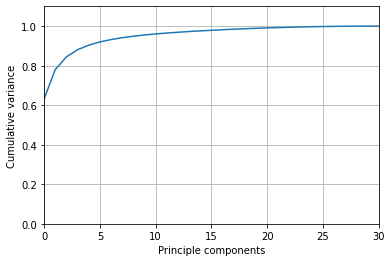

In [6]:
tot_var = eigvals.sum()
cum_vars = np.cumsum(eigvals / tot_var)

plt.plot(cum_vars)
plt.xlabel('Principle components')
plt.ylabel('Cumulative variance')
plt.ylim([0,1.1])
plt.xlim([0,30])
plt.grid()

print(cum_vars[ncomponents-1]) # cumulative variance covered by 3 principle axes

### 5. Transform into and from latent space

(10000, 3) (10000, 4096)
MSE:  1270.4723


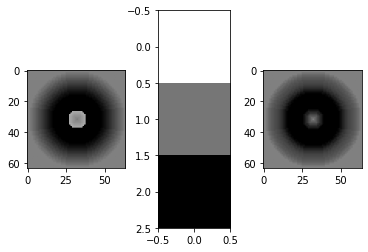

In [7]:
accounted_var, pcs = eigvals[:ncomponents], eigvecs[:, :ncomponents] # select first k principle components
Z = X @ pcs  # transform into latent space
X_pred = Z @ pcs.T
print(Z.shape, X_pred.shape)

fig, ax = plt.subplots(ncols=3, nrows=1)
ax[0].imshow(tf.reshape(X[expl_idx], (nrows, ncols)), vmin=vmin, vmax=vmax)
ax[1].imshow(tf.reshape(Z[expl_idx], (-1, 1)))
ax[2].imshow(tf.reshape(X_pred[expl_idx],(nrows, ncols)), vmin=vmin, vmax=vmax)

print("MSE: ", np.square(np.subtract(X, X_pred)).mean())

### 6. Interpolation in latent space
* The data samples transformed into $Z$ are statistically independent, i.e. the latent units are "disentangled".
* The decoded image is a linear combination of the principle components weighted by their coefficient (principle score).
* We can interpolate/fade the values of the latent components in isolation and observe the effect on the resulting reconstruction.

In [8]:
from ipywidgets import interactive
import ipywidgets as widgets

def f(**kwargs):
    z = list(kwargs.values())
    x_pred = z @ pcs.T
    plt.figure(2)
    plt.imshow(tf.reshape(x_pred,(nrows, ncols)), vmin=vmin, vmax=vmax)

# print(tf.transpose(Z))
scores = Z[expl_idx]

sliders = {f"PC{i+1}": widgets.FloatSlider(min=tf.reduce_min(z),max=tf.reduce_max(z),value=score) 
           for (i,score), z in zip(enumerate(scores), tf.transpose(Z))}

interactive(f, **sliders)
ix_plot = interactive(f, **sliders)
output = ix_plot.children[-1]
output.layout.height = '250px'
ix_plot

interactive(children=(FloatSlider(value=4810.927734375, description='PC1', max=5005.0595703125, min=-7888.6445…

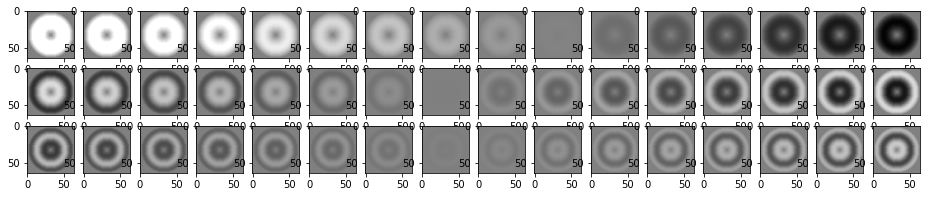

In [9]:
steps = 16
Z = X @ pcs  # transform into latent space
z_vars = [np.linspace(tf.reduce_min(z), tf.reduce_max(z), steps) for z in tf.transpose(Z)] # interpolation range

fig, axs = plt.subplots(ncols=steps, nrows=ncomponents, figsize=(steps, ncomponents))
for i in range(ncomponents):
    for j in range(steps):
        z = np.zeros_like(Z[expl_idx]) # only vary one component at a time, rest 0. Possible because latent features are not correlated.
        z[i] = z_vars[i][j]
        x_pred = z @ pcs.T
        ax = list(axs.flat)[j+i*j] if ncomponents==1 else axs[i, j]
        ax.imshow(tf.reshape(x_pred,(nrows, ncols)), vmin=vmin, vmax=vmax)

### 7. Properties of PCA
1. Decoding is reverse of encoding ("tied"): $Z=XP$, $X=ZP^T$ 
2. Orthonormal basis: $P^T P=I$ for principle component matrix $P$ and identity matrix $I$.
3. Uncorrelated latent codes: $cor(O_{i}, O_{j})=0, if i \neq j$ for i-th and j-th principle component of latent activations $O_x$. New feature axis are uncorrelated $\rightarrow$ interpolating a single neuron interpolates a single data attribute.

Dot product of all PC axes:
 [[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]
===> Identity: unit norm & dot product between off-diagonal axis 90deg (orthogonal).

tf.Tensor(
[[ 2.1129208e+07 -3.1818382e+01  3.2610260e+01]
 [-3.1818382e+01  4.9682770e+06 -1.5117512e+00]
 [ 3.2610260e+01 -1.5117512e+00  2.1559670e+06]], shape=(3, 3), dtype=float32)
===> (Mostly) uncorrelated latent activation.


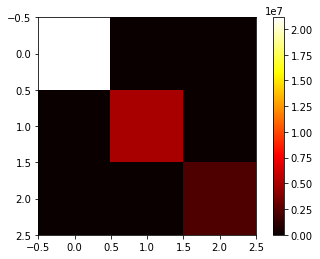

In [10]:
I = pcs.T @ pcs
print("Dot product of all PC axes:\n", np.round(I, 5))
print("===> Identity: unit norm & dot product between off-diagonal axis 90deg (orthogonal).\n")

Z = X @ pcs
Z = tf.subtract(Z, tf.reduce_mean(Z,axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples - 1)
print(Z_cov)
plt.imshow(Z_cov, cmap='hot')
plt.colorbar()
print("===> (Mostly) uncorrelated latent activation.")

### 8. Calculate MSE 
Mean error between train data and predictions in order to compare to Autoencoder performance. $\rightarrow$ MSE is not an ideal means of comparision, since two network can have the same/similar MSE but are completely different in every other regard. 

In [11]:
Z = X @ pcs
X_pred = Z @ pcs.T
np.square(np.subtract(X, X_pred)).mean()

1270.4723